In [1]:
!pip install mlxtend

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
import nltk
nltk.download('stopwords')
import matplotlib.pyplot as plt
import time
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score,log_loss
from imblearn.over_sampling import SMOTE
from collections import Counter,defaultdict
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from mlxtend.classifier import StackingClassifier
from sklearn.ensemble import VotingClassifier 
import warnings

[nltk_data] Downloading package stopwords to C:\Users\priyanka
[nltk_data]     singh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
df=pd.read_csv("C:\\Users\\priyanka singh\\Downloads\\personalized diagonesis cancer variants\\training_variants")
df.head()

,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


In [3]:
df.shape
print('No. of data points :',df.shape[0])
print('No. of data features :',df.shape[1])
print('Features :',df.columns.values)

No. of data points : 3321
No. of data features : 4
Features : ['ID' 'Gene' 'Variation' 'Class']


In [4]:
df_text = pd.read_csv("C:\\Users\\priyanka singh\\Downloads\\personalized diagonesis cancer\\training_text",sep='\|\|',names=['ID','TEXT'],skiprows=1)
df_text.head()

<ipython-input-4-70f99341ead5>:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df_text = pd.read_csv("C:\\Users\\priyanka singh\\Downloads\\personalized diagonesis cancer\\training_text",sep='\|\|',names=['ID','TEXT'],skiprows=1)


,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


In [5]:
print('No. of data points :',df_text.shape[0])
print('No. of data features :',df_text.shape[1])
print('Features :',df_text.columns.values)

No. of data points : 3321
No. of data features : 2
Features : ['ID' 'TEXT']


# Preprocessing of text 

In [6]:
stop_words = set(stopwords.words('english'))

def nlp_preprocessing(total_text,index,column):
    if type(total_text) is not int:
        string=''
        total_text = re.sub('[^a-zA-Z0-9]\n',' ',total_text)
        total_text = re.sub('\s+',' ',total_text)
        total_text=total_text.lower()
        
        for word in total_text.split():
            if not word in stop_words:
                string += word + ' '
                
        df_text[column][index] = string

In [8]:
start_time =time.process_time()
for index, row in df_text.iterrows():
    if type(row['TEXT']) is str:
        nlp_preprocessing(row['TEXT'], index, 'TEXT')
    else:
        print("there is no text description for id:",index)
print('Time took for preprocessing the text :',time.process_time() -start_time,'seconds')

<ipython-input-7-7000313cb7a6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_text[column][index] = string


there is no text description for id: 1109
there is no text description for id: 1277
there is no text description for id: 1407
there is no text description for id: 1639
there is no text description for id: 2755
Time took for preprocessing the text : 30.890625 seconds


In [9]:
result = pd.merge(df,df_text,on='ID',how='left')
result.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


In [10]:
result[result.isnull().any(axis=1)]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,NaN
1277,1277,ARID5B,Truncating Mutations,1,NaN
1407,1407,FGFR3,K508M,6,NaN
1639,1639,FLT1,Amplification,6,NaN
2755,2755,BRAF,G596C,7,NaN


In [11]:
result.loc[result['TEXT'].isnull(),'TEXT']=result['Gene']+' '+result['Variation']

In [12]:
result[result['ID']==1109]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,FANCA S1088F


# Train Test and Cross Validation Split (64:20:16)

In [14]:
y_true = result['Class'].values
result.Gene = result.Gene.str.replace('\s+','')
result.Variation = result.Variation.str.replace('\s+','')

In [15]:
X_train,X_test,y_train,y_test = train_test_split(result,y_true,stratify = y_true, test_size=0.2)
X_train_cv,X_test_cv,y_train_cv,y_test_cv = train_test_split(X_train,y_train,stratify = y_train, test_size=0.2)
#stratify for approx equal distribution of class label in each class

In [16]:
print('No. of datapoints in Training dataset :',X_train_cv.shape[0])
print('No. of datapoints in Test dataset :',X_test.shape[0])
print('No. of datapoints in CV dataset :',X_test_cv.shape[0])

No. of datapoints in Training dataset : 2124
No. of datapoints in Test dataset : 665
No. of datapoints in CV dataset : 532


# Distribution of yi's in training data, test data and cross validation data

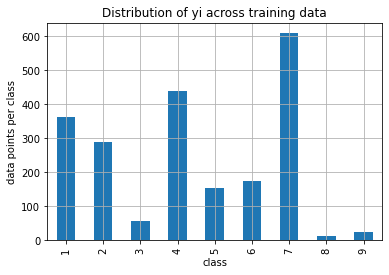

No. of data points in class 7 is 609 ( 28.672 %
No. of data points in class 4 is 439 ( 20.669 %
No. of data points in class 1 is 363 ( 17.09 %
No. of data points in class 2 is 289 ( 13.606 %
No. of data points in class 6 is 176 ( 8.286 %
No. of data points in class 5 is 155 ( 7.298 %
No. of data points in class 3 is 57 ( 2.684 %
No. of data points in class 9 is 24 ( 1.13 %
No. of data points in class 8 is 12 ( 0.565 %


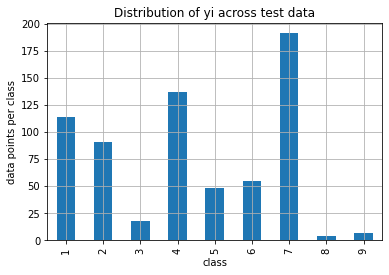

[6 3 0 1 5 4 2 8 7]
No. of data points in class 7 is 191 ( 28.722 %
No. of data points in class 4 is 137 ( 20.602 %
No. of data points in class 1 is 114 ( 17.143 %
No. of data points in class 2 is 91 ( 13.684 %
No. of data points in class 6 is 55 ( 8.271 %
No. of data points in class 5 is 48 ( 7.218 %
No. of data points in class 3 is 18 ( 2.707 %
No. of data points in class 9 is 7 ( 1.053 %
No. of data points in class 8 is 4 ( 0.602 %


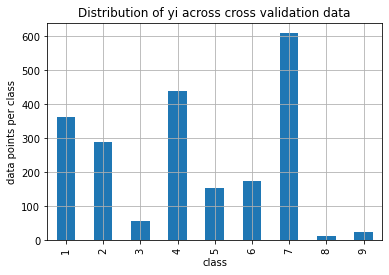

No. of data points in class 7 is 153 ( 28.759 %
No. of data points in class 4 is 110 ( 20.677 %
No. of data points in class 1 is 91 ( 17.105 %
No. of data points in class 2 is 72 ( 13.534 %
No. of data points in class 6 is 44 ( 8.271 %
No. of data points in class 5 is 39 ( 7.331 %
No. of data points in class 3 is 14 ( 2.632 %
No. of data points in class 9 is 6 ( 1.128 %
No. of data points in class 8 is 3 ( 0.564 %


In [17]:
train_class_dist = X_train_cv['Class'].value_counts().sort_index()
test_class_dist = X_test['Class'].value_counts().sort_index()
cv_class_dist = X_test_cv['Class'].value_counts().sort_index()

train_class_dist.plot(kind='bar')
plt.xlabel('class')
plt.ylabel('data points per class')
plt.title('Distribution of yi across training data')
plt.grid()
plt.show()

sorted_yi = np.argsort(-train_class_dist.values)#it sorts the index as per the high values[6 3 0 1 5 4 2 8 7]
for i in sorted_yi:
    print('No. of data points in class',i+1,'is',train_class_dist.values[i],'(',np.round((train_class_dist.values[i]/X_train_cv.shape[0]*100),3),'%')

test_class_dist.plot(kind='bar')
plt.xlabel('class')
plt.ylabel('data points per class')
plt.title('Distribution of yi across test data')
plt.grid()
plt.show()


sorted_yi = np.argsort(-test_class_dist.values)
print(sorted_yi)
for i in sorted_yi:
    print('No. of data points in class',i+1,'is',test_class_dist.values[i],'(',np.round((test_class_dist.values[i]/X_test.shape[0]*100),3),'%')

    
train_class_dist.plot(kind='bar')
plt.xlabel('class')
plt.ylabel('data points per class')
plt.title('Distribution of yi across cross validation data')
plt.grid()
plt.show()

sorted_yi = np.argsort(-cv_class_dist.values)
for i in sorted_yi:
    print('No. of data points in class',i+1,'is',cv_class_dist.values[i],'(',np.round((cv_class_dist.values[i]/X_test_cv.shape[0]*100),3),'%')

# From above we can make out that data is imbalanced in above multivlass problem and train, test and cv have similar distribution of class labels

# Prediction Using A Random Classifier

In [18]:
def plot_confusion_matrix(y_test,y_predict):
    C = confusion_matrix(y_test,y_predict)
    A = (((C.T)/(C.sum(axis=1))).T)
    B = (C/C.sum(axis=0))
    
    labels=[1,2,3,4,5,6,7,8,9]
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(12,7))
    sns.heatmap(C,annot=True,cmap='coolwarm',xticklabels=labels,yticklabels=labels)
    plt.xlabel('Predicted class')
    plt.ylabel('Actual class')
    plt.show()
    
    print("-"*20, "Precision matrix", "-"*20)
    plt.figure(figsize=(12,7))
    sns.heatmap(B,annot=True,cmap='coolwarm',xticklabels=labels,yticklabels=labels)
    plt.xlabel('Predicted class')
    plt.ylabel('Actual class')
    plt.show()
    
    print("-"*20, "Recall matrix", "-"*20)
    plt.figure(figsize=(12,7))
    sns.heatmap(A,annot=True,cmap='coolwarm',xticklabels=labels,yticklabels=labels)
    plt.xlabel('Predicted class')
    plt.ylabel('Actual class')
    plt.show()

Log-loss on cross validation data using random model 2.5153787366666043
Log-loss on test data using random model 2.4792879354352393
-------------------- Confusion matrix --------------------


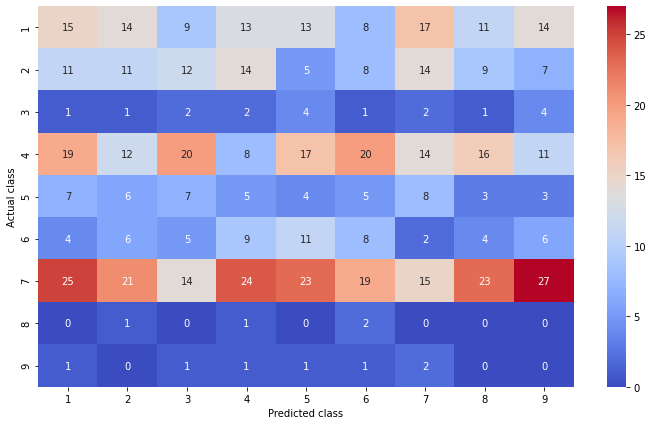

-------------------- Precision matrix --------------------


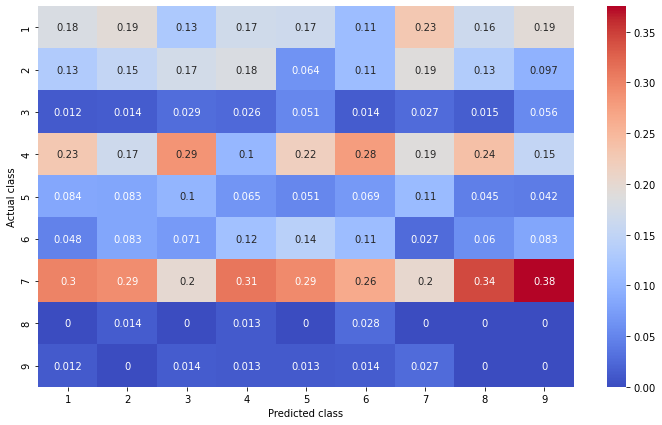

-------------------- Recall matrix --------------------


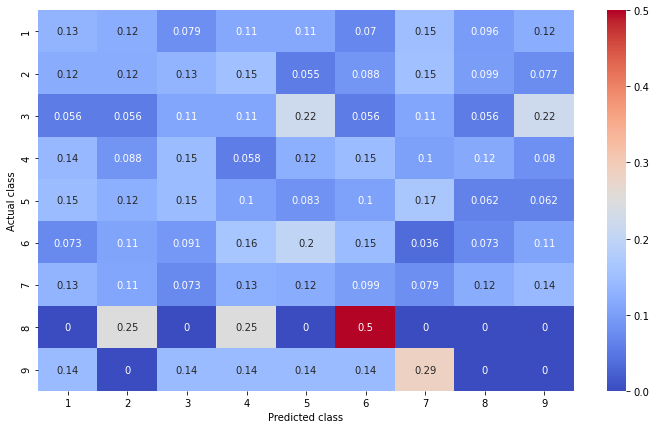

In [19]:
test_data_len = X_test.shape[0]
cv_data_len = X_test_cv.shape[0]

cv_predicted_y = np.zeros((cv_data_len,9))
for i in range(cv_data_len):
    rand_prob = np.random.rand(1,9)
    cv_predicted_y[i] = ((rand_prob/sum(sum(rand_prob)))) #Log loss is undefined for p=0 or p=1, so probabilities are clipped to max(eps, min(1 - eps, p))
print('Log-loss on cross validation data using random model',log_loss(y_test_cv,cv_predicted_y,eps=1e-15))

test_predicted_y = np.zeros((test_data_len,9))
for i in range(test_data_len):
    rand_probs = np.random.rand(1,9)
    test_predicted_y[i] = ((rand_probs/sum(sum(rand_probs))))
print('Log-loss on test data using random model',log_loss(y_test,test_predicted_y,eps=1e-15))
  
predicted_y = np.argmax(test_predicted_y,axis=1)
plot_confusion_matrix(y_test,predicted_y+1)

In [22]:
uniqu_gene=X_train_cv['Gene'].value_counts()
print('No. of unique gene',uniqu_gene.shape[0])
print(uniqu_gene.head(10))

No. of unique gene 235
BRCA1     172
TP53      105
EGFR       93
BRCA2      88
PTEN       83
KIT        61
BRAF       57
ERBB2      45
ALK        43
PDGFRA     39
Name: Gene, dtype: int64


# How Gene is distributed

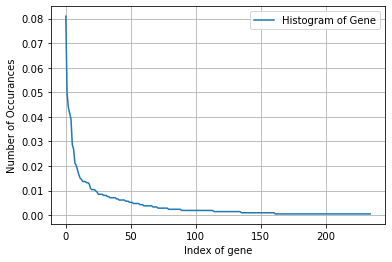

In [23]:
s=sum(uniqu_gene.values);
h=uniqu_gene.values/s;
plt.plot(h,label='Histogram of Gene')
plt.xlabel('Index of gene')
plt.ylabel('Number of Occurances')
plt.grid()
plt.legend()
plt.show()

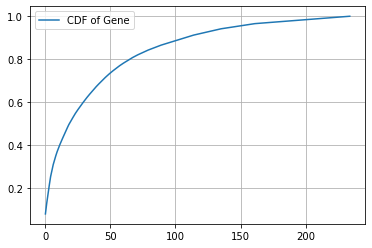

In [24]:
c=np.cumsum(h)
plt.plot(c,label='CDF of Gene')
plt.grid()
plt.legend()
plt.show()

In [25]:
#50 features in gene contribute around more thna 70% of the data

In [26]:
X_test_cv['Gene']

337       ROS1
1822      RHOA
3157      KRAS
1417     FGFR3
536      SMAD2
         ...  
1067     EWSR1
2927    NFE2L2
82        RIT1
86       CCNE1
55       PTPRT
Name: Gene, Length: 532, dtype: object

In [ ]:
gene_vectorizer = CountVectorizer()
train_gene_feature_onehotCoding = gene_vectorizer.fit_transform(X_train_cv['Gene'])
test_gene_feature_onehotCoding = gene_vectorizer.transform(X_test['Gene'])
cv_gene_feature_onehotCoding = gene_vectorizer.transform(X_test_cv['Gene'])

In [30]:
train_gene_feature_onehot.shape

(2124, 234)

# How good is this gene feature in predicting y_i?

***There are many ways to estimate how good a feature is, in predicting y_i. One of the good methods is to build a proper ML model using just this feature. In this case, we will build a logistic regression model using only Gene feature (one hot encoded) to predict y_i.

In [31]:
alpha=[10**x for x in range(-5,1)]
alpha

[1e-05, 0.0001, 0.001, 0.01, 0.1, 1]

For value of alpha 1e-05 log_loss is 1.2625462226035324
For value of alpha 0.0001 log_loss is 1.254266617761757
For value of alpha 0.001 log_loss is 1.2958477130795771
For value of alpha 0.01 log_loss is 1.4053571295776626
For value of alpha 0.1 log_loss is 1.4782070097634255
For value of alpha 1 log_loss is 1.5130672760809918


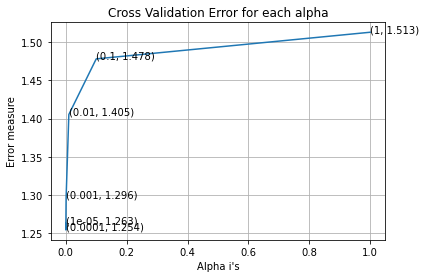

For value of alpha 0.0001 train_log_loss is 0.9713133859385964
For value of alpha 0.0001 test_log_loss is 1.166024133108974
For value of alpha 0.0001 cv_log_loss is 1.254266617761757


In [32]:
cv_log_error=[]
for i in alpha:
    clf = SGDClassifier(alpha=i,penalty='l2',random_state=42,loss='log')
    clf.fit(train_gene_feature_onehot,y_train_cv)
    sig_clf =CalibratedClassifierCV(clf,method='sigmoid')
    sig_clf.fit(train_gene_feature_onehot,y_train_cv)
    predict_y = sig_clf.predict_proba(cv_gene_feature_onehot)
    cv_log_error.append(log_loss(y_test_cv,predict_y,labels=clf.classes_,eps=1e-15))
    print('For value of alpha',i,'log_loss is',log_loss(y_test_cv,predict_y,labels=clf.classes_,eps=1e-15))
    
fig,ax = plt.subplots()
ax.plot(alpha,cv_log_error)
for i,text in enumerate(np.round(cv_log_error,3)):
    ax.annotate((alpha[i],np.round(text,3)),(alpha[i],cv_log_error[i]))       # it i used to placed the text at xy.
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

bestalpha=np.argmin(cv_log_error)
clf=SGDClassifier(alpha=alpha[bestalpha],loss='log',random_state=42,penalty='l2')
clf.fit(train_gene_feature_onehot,y_train_cv)
sig_clf=CalibratedClassifierCV(clf,method='sigmoid')
sig_clf.fit(train_gene_feature_onehot,y_train_cv)

predict_y = sig_clf.predict_proba(train_gene_feature_onehot)
print('For value of alpha',alpha[bestalpha],'train_log_loss is',log_loss(y_train_cv,predict_y,labels=clf.classes_,eps=1e-15))
    
predict_y = sig_clf.predict_proba(test_gene_feature_onehot)
print('For value of alpha',alpha[bestalpha],'test_log_loss is',log_loss(y_test,predict_y,labels=clf.classes_,eps=1e-15))
    
predict_y = sig_clf.predict_proba(cv_gene_feature_onehot)
print('For value of alpha',alpha[bestalpha],'cv_log_loss is',log_loss(y_test_cv,predict_y,labels=clf.classes_,eps=1e-15))
    

***5.Is the Gene feature stable across all the data sets (Test, Train, Cross validation)?

***Ans. Yes, it is. Otherwise, the CV and Test errors would be significantly more than train error.

# Univariate Analysis:Variation Feature

In [33]:
unique_variation = X_train_cv['Variation'].value_counts()
print('No. of unique variation ',unique_variation.shape[0])
print(unique_variation.head(10))

No. of unique variation  1928
TruncatingMutations    65
Deletion               45
Amplification          38
Fusions                23
Overexpression          5
Q61L                    3
A146T                   2
TMPRSS2-ETV1Fusion      2
E330K                   2
Q61R                    2
Name: Variation, dtype: int64


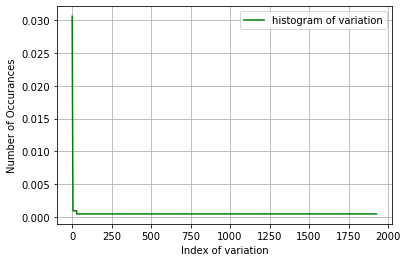

In [34]:
s=sum(unique_variation.values)
h=unique_variation.values/s
plt.plot(h,label='histogram of variation',color='g')
plt.xlabel('Index of variation')
plt.ylabel('Number of Occurances')
plt.legend()
plt.grid()
plt.show()

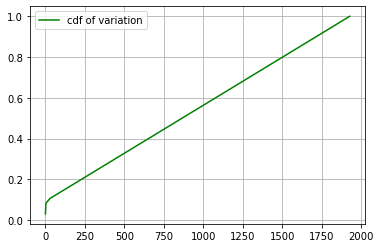

In [35]:
c=np.cumsum(h)
plt.plot(c,label='cdf of variation',color='g')
plt.legend()
plt.grid()
plt.show()

In [36]:
#FEATURIZATION OF VARIATION
alpha=1
train_variation_responsecoding = np.array(get_gv_feature(alpha,'Variation',X_train_cv))
test_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation",X_test))
cv_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", X_test_cv))

In [37]:
train_variation_responsecoding.shape

(2124, 9)

In [38]:
variation_vectorizer=CountVectorizer()
train_variation_onehot=variation_vectorizer.fit_transform(X_train_cv['Variation'])
test_variation_onehot=variation_vectorizer.transform(X_test['Variation'])
cv_variation_onehot=variation_vectorizer.transform(X_test_cv['Variation'])

# How good is variation in predicting yi

For values of alpha =  1e-05 The log loss is: 1.7196207223260955
For values of alpha =  0.0001 The log loss is: 1.710750007712108
For values of alpha =  0.001 The log loss is: 1.7176654160922349
For values of alpha =  0.01 The log loss is: 1.7310004642490695
For values of alpha =  0.1 The log loss is: 1.7401502961793234
For values of alpha =  1 The log loss is: 1.7412140984413753


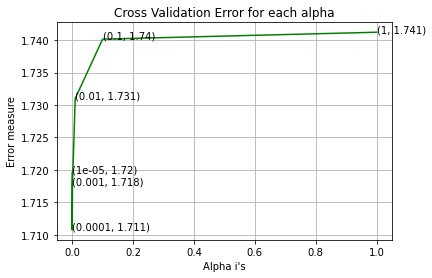

For values of best alpha =  0.0001 The train log loss is: 0.6844395579694468
For values of best alpha =  0.0001 The test log loss is: 1.717871868849225
For values of best alpha =  0.0001 The cv log loss is: 1.710750007712108


In [39]:
alpha = [10 ** x for x in range(-5, 1)]
cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_variation_onehot, y_train_cv)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_variation_onehot, y_train_cv)
    predict_y = sig_clf.predict_proba(cv_variation_onehot)
    
    cv_log_error_array.append(log_loss(y_test_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_variation_onehot, y_train_cv)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_variation_onehot, y_train_cv)

predict_y = sig_clf.predict_proba(train_variation_onehot)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_variation_onehot)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_variation_onehot)
print('For values of best alpha = ', alpha[best_alpha], "The cv log loss is:",log_loss(y_test_cv, predict_y, labels=clf.classes_, eps=1e-15))

In [40]:
print("Q12. How many data points are covered by total ", unique_variation.shape[0], " genes in test and cross validation data sets?")

test_coverage=X_test[X_test['Variation'].isin(list(set(X_train_cv['Variation'])))].shape[0]
cv_coverage=X_test_cv[X_test_cv['Variation'].isin(list(set(X_train_cv['Variation'])))].shape[0]
print('data points are covered in test data ',test_coverage,'out of total',X_test.shape[0])
print('data points are covered in cv data ',cv_coverage,'out of total',X_test_cv.shape[0])

Q12. How many data points are covered by total  1928  genes in test and cross validation data sets?
data points are covered in test data  68 out of total 665
data points are covered in cv data  50 out of total 532


# Univariate Analysis on Text Feature

In [41]:
print('How many unique words are present in the train data')

How many unique words are present in the train data


In [42]:
def extract_dictionary(cls_txt):
    dictionary=defaultdict(int)
    for index,row in cls_txt.iterrows():
        for word in row['TEXT'].split():
            dictionary[word]+=1
    return dictionary

In [43]:
#Applying responsecoding on categorical variables
import math
#pending

In [44]:
# building a CountVectorizer with all the words that occured minimum 3 times in train data
text_vectorizer=CountVectorizer(min_df=3)
train_text_one_hot = text_vectorizer.fit_transform(X_train_cv['TEXT'])

train_text_feature = text_vectorizer.get_feature_names()
train_text_feature_count=train_text_one_hot.sum(axis=0).A1

text_fea_dict=dict(zip(train_text_feature,train_text_feature_count))
print('Total no. of unique words in train data ',len(train_text_feature))

Total no. of unique words in train data  53436


In [45]:
dict_list=[]
for i in range(1,10):
    cls_txt=X_train_cv[X_train_cv['Class']==1]
    dict_list.append(extract_dictionary(cls_txt))
    
total_dict=extract_dictionary(X_train_cv)

confuse_array=[]
for i in train_text_feature:
    ratio=[]
    max_val=-1
    for j in range(0,9):
        ratio.append((dict_list[j][i]+10)/(total_dict[i]+90))
    confuse_array.append(ratio)
    
confuse_array=np.array(confuse_array)

In [46]:
train_text_one_hot=normalize(train_text_one_hot,axis=0)

test_text_one_hot = text_vectorizer.transform(X_test['TEXT'])
test_text_one_hot = normalize(test_text_one_hot, axis=0)

cv_text_one_hot = text_vectorizer.transform(X_test_cv['TEXT'])
cv_text_one_hot = normalize(cv_text_one_hot,axis=0)
cv_text_one_hot.shape
print(y_train_cv.shape)
print(y_test_cv.shape)
print(train_text_one_hot.shape)
print(cv_text_one_hot.shape)

(2124,)
(532,)
(2124, 53436)
(532, 53436)


In [47]:
sorted_text_fea_dict = dict(sorted(text_fea_dict.items(),key=lambda x:x[1],reverse=True))
sorted_text_occur = np.array(list(sorted_text_fea_dict.values()))

In [48]:
sorted_text_occur

array([154717, 119553,  81134, ...,      3,      3,      3], dtype=int64)

In [49]:
# Number of words for a given frequency.
print(Counter(sorted_text_occur))

Counter({3: 5612, 4: 3468, 5: 2816, 6: 2728, 7: 2176, 9: 1960, 8: 1878, 10: 1421, 12: 1227, 11: 1185, 15: 1047, 14: 959, 18: 876, 13: 847, 16: 733, 20: 558, 21: 545, 17: 536, 22: 517, 24: 502, 19: 462, 28: 437, 23: 433, 27: 381, 30: 351, 25: 349, 48: 344, 45: 344, 29: 337, 33: 321, 26: 316, 36: 307, 32: 279, 31: 267, 35: 244, 34: 231, 37: 217, 40: 207, 42: 202, 39: 197, 44: 184, 43: 182, 41: 174, 38: 174, 52: 173, 46: 159, 51: 151, 54: 147, 50: 146, 49: 146, 56: 142, 57: 137, 60: 134, 58: 134, 47: 133, 55: 129, 64: 127, 53: 124, 59: 121, 67: 119, 63: 113, 72: 105, 96: 99, 70: 99, 68: 99, 61: 97, 65: 95, 73: 94, 66: 93, 78: 92, 80: 91, 90: 89, 71: 89, 62: 89, 69: 81, 75: 78, 81: 77, 84: 76, 83: 76, 77: 75, 82: 74, 97: 73, 76: 73, 87: 70, 89: 67, 109: 66, 74: 66, 98: 65, 86: 65, 93: 64, 105: 63, 79: 63, 144: 60, 85: 60, 95: 58, 103: 57, 94: 57, 102: 56, 88: 56, 116: 55, 112: 55, 108: 55, 92: 55, 114: 54, 111: 53, 100: 53, 91: 52, 104: 48, 120: 47, 113: 46, 99: 44, 134: 43, 127: 43, 152: 

For value of alpha 1e-05 Log_loss is  1.3669408537815295
For value of alpha 0.0001 Log_loss is  1.2741710146132121
For value of alpha 0.001 Log_loss is  1.2935994148919105
For value of alpha 0.01 Log_loss is  1.3838539938828842
For value of alpha 0.1 Log_loss is  1.5817241408264748
For value of alpha 1 Log_loss is  1.7571031865725217


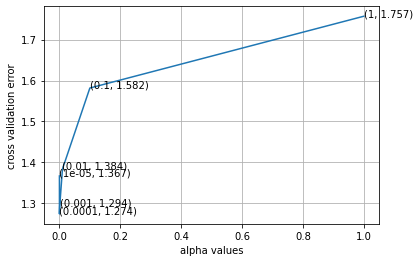

For values of best alpha =  0.0001 The train log loss is: 0.6457059755851307
For values of best alpha =  0.0001 The cross validation log loss is: 1.2741710146132121
For values of best alpha =  0.0001 The test log loss is: 1.1865553553785892


In [50]:
alpha=[10**x for x in range(-5,1)]
cv_error_loss=[]
for i in alpha:
    clf=SGDClassifier(alpha=i,penalty='l2',loss='log',random_state=42)
    clf.fit(train_text_one_hot,y_train_cv)
    sig_clf=CalibratedClassifierCV(clf,method='sigmoid')
    sig_clf.fit(train_text_one_hot,y_train_cv)
    predicted_y=sig_clf.predict_proba(cv_text_one_hot)
    cv_error_loss.append(log_loss(y_test_cv,predicted_y,labels=clf.classes_,eps=1e-15))
    print('For value of alpha',i,'Log_loss is ',log_loss(y_test_cv,predicted_y,labels=clf.classes_,eps=1e-15))
    

fig,ax=plt.subplots()
ax.plot(alpha,cv_error_loss)

for i,text in enumerate(np.round(cv_error_loss,3)):
    ax.annotate((alpha[i],np.round(text,3)),(alpha[i],cv_error_loss[i]))
plt.xlabel('alpha values')
plt.ylabel('cross validation error')
plt.grid()
plt.show()

bestalpha=np.argmin(cv_error_loss)
clf=SGDClassifier(alpha=alpha[bestalpha],penalty='l2',loss='log',random_state=42)
clf.fit(train_text_one_hot,y_train_cv)
sig_clf=CalibratedClassifierCV(clf,method='sigmoid')
sig_clf.fit(train_text_one_hot,y_train_cv)

predict_y = sig_clf.predict_proba(train_text_one_hot)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_text_one_hot)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_test_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_text_one_hot)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


# Machine learning Models

In [120]:
def predict_and_plot_confusion_matrix(x_train,y_train,x_test,y_test,clf):
    clf.fit(x_train,y_train)
    sig_clf = CalibratedClassifierCV(clf,method='sigmoid')
    sig_clf.fit(x_train,y_train)
    pred_y=sig_clf.predict(x_test)
    
    print('Log_loss ',log_loss(y_test,sig_clf.predict_proba(x_test)))
    print('Number of misclassified points',np.count_nonzero((pred_y-y_test))/y_test.shape[0])
    plot_confusion_matrix(y_test,pred_y)

In [52]:
def report_log_loss(x_train,y_train,x_test,y_test,clf):
    clf.fit(x_train,y_train)
    sig_clf = CalibratedClassifierCV(clf,method='sigmoid')
    sig_clf.fit(x_train,y_train)
    sig_clf_prob = sig_clf.predict_proba(x_test)
    return log_loss(y_test,sig_clf_prob,eps=1e-15)

# Stacking of features

In [74]:
train_gene_var_onehot = hstack((train_gene_feature_onehot,train_variation_onehot))
test_gene_var_onehot = hstack((test_gene_feature_onehot,test_variation_onehot))
cv_gene_var_onehot = hstack((cv_gene_feature_onehot,cv_variation_onehot))

train_x_onehot = hstack((train_gene_var_onehot,train_text_one_hot)).tocsr()
train_y = np.array(list(X_train_cv['Class']))

test_x_onehot = hstack((test_gene_var_onehot,test_text_one_hot)).tocsr()
test_y = np.array(list(X_test['Class']))

cv_x_onehot = hstack((cv_gene_var_onehot,cv_text_one_hot)).tocsr()
cv_y = np.array(list(X_test_cv['Class']))

In [75]:
print("One hot encoding features :")
print("(number of data points * number of features) in train data = ", train_x_onehot.shape)
print("(number of data points * number of features) in test data = ", test_x_onehot.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_onehot.shape)

One hot encoding features :
(number of data points * number of features) in train data =  (2124, 55629)
(number of data points * number of features) in test data =  (665, 55629)
(number of data points * number of features) in cross validation data = (532, 55629)


# Naive Bayes

Log_loss  1.321502712767759
Log_loss  1.324245047644346
Log_loss  1.3328511856178615
Log_loss  1.3438218726626763
Log_loss  1.3409195101113123
Log_loss  1.3798247374842716
Log_loss  1.3952846696820502
Log_loss  1.3683784253885047


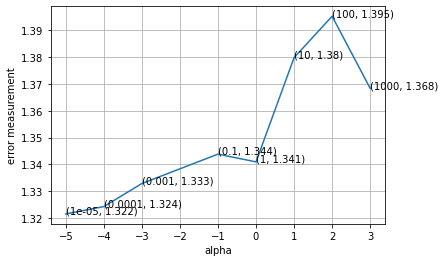

train Log_loss  0.7728642822977574
Test Log_loss  1.2701825889050071
CV Log_loss  1.321502712767759


In [76]:
alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
cv_log_error=[]
for i in alpha:
    clf = MultinomialNB(alpha=i)
    clf.fit(train_x_onehot,train_y)
    sig_clf=CalibratedClassifierCV(clf,method='sigmoid')
    sig_clf.fit(train_x_onehot,train_y)
    sig_clf_prob=sig_clf.predict_proba(cv_x_onehot)
    cv_log_error.append(log_loss(cv_y,sig_clf_prob,labels=clf.classes_,eps=1e-15))
    print('Log_loss ',log_loss(cv_y,sig_clf_prob,labels=clf.classes_,eps=1e-15))
    
fig,ax=plt.subplots()
ax.plot(np.log10(alpha),cv_log_error)

for i,text in enumerate(np.round(cv_log_error,3)):
    ax.annotate((alpha[i],np.round(text,3)),(np.log10(alpha[i]),cv_log_error[i]))
                
plt.xlabel('alpha')
plt.ylabel('error measurement')
plt.grid()
plt.show()

bestalpha=np.argmin(cv_log_error)
clf = MultinomialNB(alpha=alpha[bestalpha])
clf.fit(train_x_onehot,train_y)
sig_clf=CalibratedClassifierCV(clf,method='sigmoid')
sig_clf.fit(train_x_onehot,train_y)

sig_clf_prob=sig_clf.predict_proba(train_x_onehot)
print('train Log_loss ',log_loss(y_train_cv,sig_clf_prob,labels=clf.classes_,eps=1e-15))

sig_clf_prob=sig_clf.predict_proba(test_x_onehot)
print('Test Log_loss ',log_loss(y_test,sig_clf_prob,labels=clf.classes_,eps=1e-15))

sig_clf_prob=sig_clf.predict_proba(cv_x_onehot)
print('CV Log_loss ',log_loss(y_test_cv,sig_clf_prob,labels=clf.classes_,eps=1e-15))

# Testing the model with best hyper paramters

Log_loss  1.321502712767759
Number of misclassified points 0.41541353383458646


<ipython-input-18-0c2a6ba47767>:4: RuntimeWarning: invalid value encountered in true_divide
  B = (C/C.sum(axis=0))


-------------------- Confusion matrix --------------------


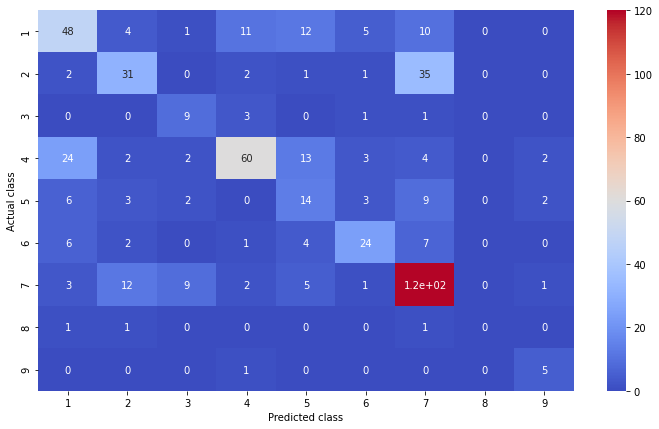

-------------------- Precision matrix --------------------


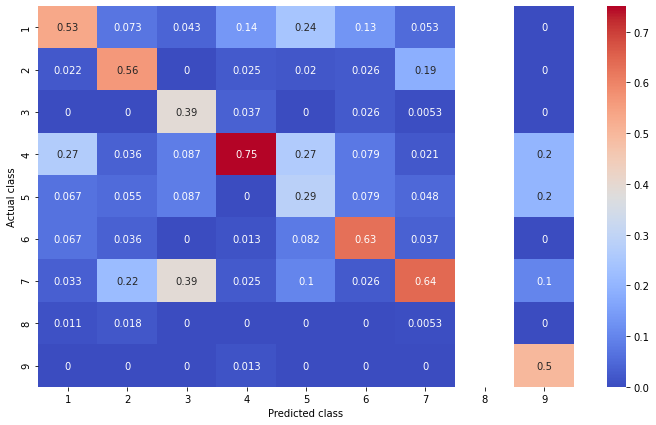

-------------------- Recall matrix --------------------


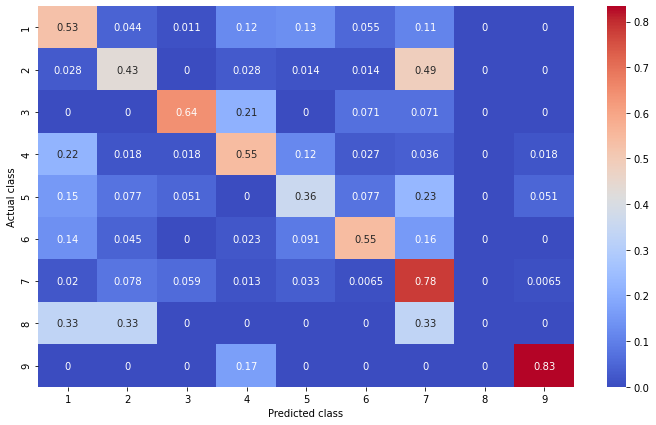

In [77]:
clf=MultinomialNB(alpha=alpha[bestalpha])
clf.fit(train_x_onehot,train_y)
sig_clf=CalibratedClassifierCV(clf,method='sigmoid')
sig_clf.fit(train_x_onehot,train_y)
sig_clf_prob=sig_clf.predict_proba(cv_x_onehot)
print('Log_loss ',log_loss(cv_y,sig_clf_prob))
print('Number of misclassified points',np.count_nonzero((sig_clf.predict(cv_x_onehot)-cv_y))/cv_y.shape[0])
plot_confusion_matrix(cv_y,sig_clf.predict(cv_x_onehot.toarray()))

# Feature Importance, Correctly classified point

In [111]:
test_point_index=95
no_features=100
predicted_cls=sig_clf.predict(test_x_onehot[test_point_index])
print('Predicted class ',predicted_cls[0])
print('predicetd class probabilties :',np.round(sig_clf.predict_proba(test_x_onehot[test_point_index]),4))
print('Actual_class: ',y_test[test_point_index])


Predicted class  4
predicetd class probabilties : [[0.0795 0.0773 0.0114 0.6633 0.0305 0.0323 0.0948 0.0057 0.0051]]
Actual_class:  4
--------------------------------------------------
Out of the top  100  features  0 are present in query point


# Logistic Regression

Log_Loss  1.3857359064397432
Log_Loss  1.3673700272891625
Log_Loss  1.235724657291927
Log_Loss  1.2209454991821058
Log_Loss  1.3253464782073792
Log_Loss  1.5563774538886048
Log_Loss  1.7355471993259204
Log_Loss  1.7527589265811079
Log_Loss  1.7545125741266996


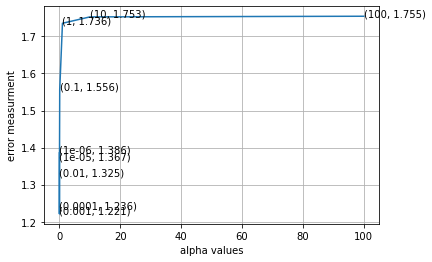

Train Log_Loss  0.49703953685785046
test Log_Loss  1.1202004999856967
cv Log_Loss  1.2209454991821058


In [117]:
alpha=[10**x for x in range(-6,3)]
cv_log_error=[]
for i in alpha:
    clf=SGDClassifier(class_weight='balanced',penalty='l2',loss='log',alpha=i,random_state=42)
    clf.fit(train_x_onehot,train_y)
    sig_cls=CalibratedClassifierCV(clf,method='sigmoid')
    sig_cls.fit(train_x_onehot,train_y)
    predict_y=sig_cls.predict_proba(cv_x_onehot)
    cv_log_error.append(log_loss(cv_y,predict_y,labels=clf.classes_,eps=1e-15))
    print('Log_Loss ',log_loss(cv_y,predict_y,labels=clf.classes_,eps=1e-15))
    
fig,ax=plt.subplots()
ax.plot(alpha,cv_log_error)
for i,text in enumerate(np.round(cv_log_error,3)):
    ax.annotate((alpha[i],np.round(text,3)),(alpha[i],cv_log_error[i]))
    
plt.xlabel('alpha values')
plt.ylabel('error measurment')
plt.grid()
plt.show()

bestalpha=np.argmin(cv_log_error)
clf=SGDClassifier(class_weight='balanced',penalty='l2',loss='log',alpha=alpha[bestalpha],random_state=42)
clf.fit(train_x_onehot,train_y)
sig_cls=CalibratedClassifierCV(clf,method='sigmoid')
sig_cls.fit(train_x_onehot,train_y)

predict_y=sig_cls.predict_proba(train_x_onehot)
print('Train Log_Loss ',log_loss(y_train_cv,predict_y,labels=clf.classes_,eps=1e-15))

predict_y=sig_cls.predict_proba(test_x_onehot)
print('test Log_Loss ',log_loss(y_test,predict_y,labels=clf.classes_,eps=1e-15))

predict_y=sig_cls.predict_proba(cv_x_onehot)
print('cv Log_Loss ',log_loss(y_test_cv,predict_y,labels=clf.classes_,eps=1e-15))

# Testing the model with best hyper paramters

Log_loss  1.2209454991821058
Number of misclassified points 0.36278195488721804
-------------------- Confusion matrix --------------------


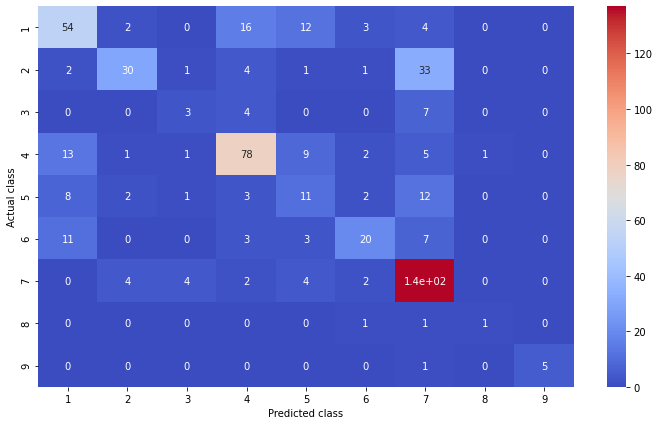

-------------------- Precision matrix --------------------


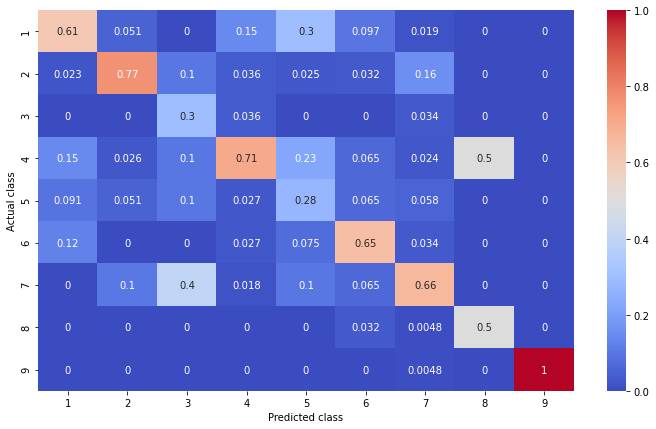

-------------------- Recall matrix --------------------


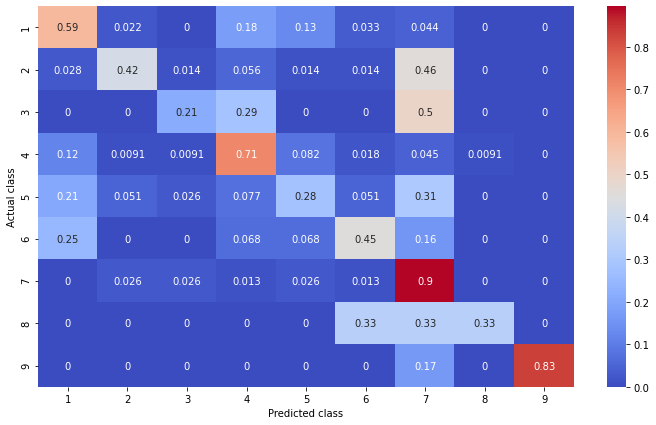

In [121]:
clf=SGDClassifier(class_weight='balanced',penalty='l2',loss='log',alpha=alpha[bestalpha],random_state=42)
predict_and_plot_confusion_matrix(train_x_onehot,train_y,cv_x_onehot,cv_y,clf)

In [145]:
test_point_index=1
no_features=100
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehot,train_y)
sig_clf=CalibratedClassifierCV(clf,method='sigmoid')
sig_clf.fit(train_x_onehot,train_y)
predicted_class=sig_clf.predict(test_x_onehot[test_point_index])
print('Predicted_class :',predicted_class[0])
print('Probability of belonging to each class :',sig_clf.predict_proba(test_x_onehot[test_point_index]))
print('Actual class :',test_y[test_point_index])#coef_is the weight here
print('-'*50)


Predicted_class : 1
Probability of belonging to each class : [[0.39131013 0.10323304 0.00148925 0.12528406 0.00742342 0.01142252
  0.33790403 0.01354785 0.00838571]]
Actual class : 4
--------------------------------------------------
Out of the top  100  features  0 are present in query point


# Logistic Regression without class balance

Log_Loss  1.3899889057849306
Log_Loss  1.3398759540877867
Log_Loss  1.2600009146757518
Log_Loss  1.2254951672288836
Log_Loss  1.3203214584067826
Log_Loss  1.4897643318032903
Log_Loss  1.7172551442184452
Log_Loss  1.744617934836339
Log_Loss  1.7473207035786456


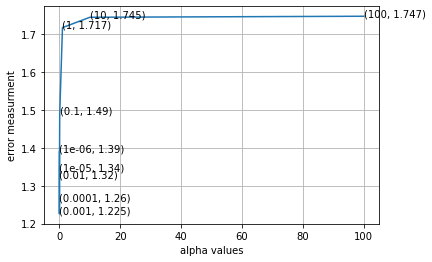

Train Log_Loss  0.4970593888192593
test Log_Loss  1.129915630295468
cv Log_Loss  1.2254951672288836


In [146]:
alpha=[10**x for x in range(-6,3)]
cv_log_error=[]
for i in alpha:
    clf=SGDClassifier(penalty='l2',loss='log',alpha=i,random_state=42)
    clf.fit(train_x_onehot,train_y)
    sig_cls=CalibratedClassifierCV(clf,method='sigmoid')
    sig_cls.fit(train_x_onehot,train_y)
    predict_y=sig_cls.predict_proba(cv_x_onehot)
    cv_log_error.append(log_loss(cv_y,predict_y,labels=clf.classes_,eps=1e-15))
    print('Log_Loss ',log_loss(cv_y,predict_y,labels=clf.classes_,eps=1e-15))
    
fig,ax=plt.subplots()
ax.plot(alpha,cv_log_error)
for i,text in enumerate(np.round(cv_log_error,3)):
    ax.annotate((alpha[i],np.round(text,3)),(alpha[i],cv_log_error[i]))
    
plt.xlabel('alpha values')
plt.ylabel('error measurment')
plt.grid()
plt.show()

bestalpha=np.argmin(cv_log_error)
clf=SGDClassifier(penalty='l2',loss='log',alpha=alpha[bestalpha],random_state=42)
clf.fit(train_x_onehot,train_y)
sig_cls=CalibratedClassifierCV(clf,method='sigmoid')
sig_cls.fit(train_x_onehot,train_y)

predict_y=sig_cls.predict_proba(train_x_onehot)
print('Train Log_Loss ',log_loss(y_train_cv,predict_y,labels=clf.classes_,eps=1e-15))

predict_y=sig_cls.predict_proba(test_x_onehot)
print('test Log_Loss ',log_loss(y_test,predict_y,labels=clf.classes_,eps=1e-15))

predict_y=sig_cls.predict_proba(cv_x_onehot)
print('cv Log_Loss ',log_loss(y_test_cv,predict_y,labels=clf.classes_,eps=1e-15))

Log_loss  1.2254951672288836
Number of misclassified points 0.3684210526315789
-------------------- Confusion matrix --------------------


<ipython-input-18-0c2a6ba47767>:4: RuntimeWarning: invalid value encountered in true_divide
  B = (C/C.sum(axis=0))


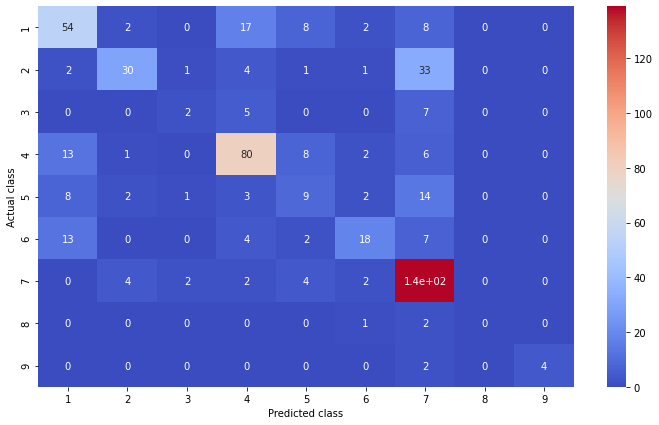

-------------------- Precision matrix --------------------


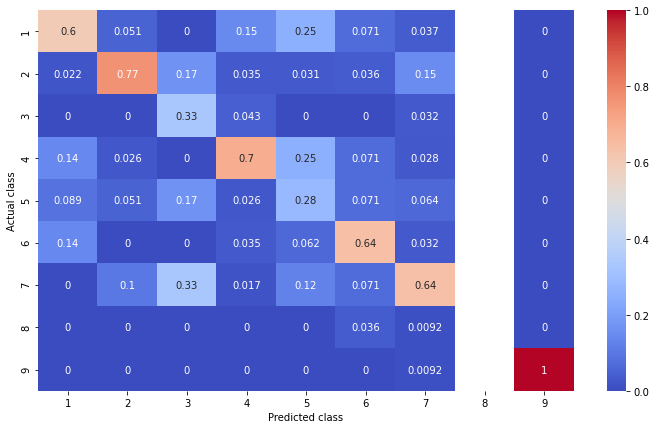

-------------------- Recall matrix --------------------


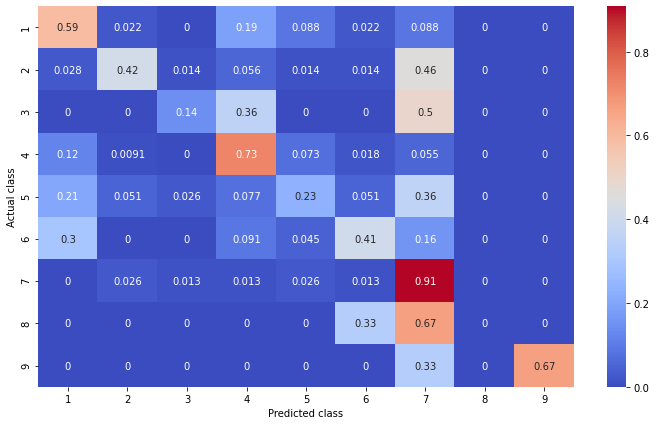

In [147]:
clf=SGDClassifier(penalty='l2',loss='log',alpha=alpha[bestalpha],random_state=42)
predict_and_plot_confusion_matrix(train_x_onehot,train_y,cv_x_onehot,cv_y,clf)

In [150]:
test_point_index=7
no_features=100
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehot,train_y)
sig_clf=CalibratedClassifierCV(clf,method='sigmoid')
sig_clf.fit(train_x_onehot,train_y)
predicted_class=sig_clf.predict(test_x_onehot[test_point_index])
print('Predicted_class :',predicted_class[0])
print('Probability of belonging to each class :',sig_clf.predict_proba(test_x_onehot[test_point_index]))
print('Actual class :',test_y[test_point_index])#coef_is the weight here
print('-'*50)


Predicted_class : 1
Probability of belonging to each class : [[6.88564138e-01 4.36013287e-02 1.86822391e-04 4.71501193e-02
  9.49664529e-04 4.88094098e-03 1.96277995e-01 1.24150867e-02
  5.97390354e-03]]
Actual class : 1
--------------------------------------------------
Out of the top  100  features  0 are present in query point


# Linear Support Vector Machines


Log_loss for alpha  1e-06 is  1.4025919837219063
Log_loss for alpha  1e-05 is  1.3636113684441487
Log_loss for alpha  0.0001 is  1.3200173033122953
Log_loss for alpha  0.001 is  1.2230024764439569
Log_loss for alpha  0.01 is  1.2109459031940473
Log_loss for alpha  0.1 is  1.4467792099120036
Log_loss for alpha  1 is  1.745400151656925
Log_loss for alpha  10 is  1.7548040659982225
Log_loss for alpha  100 is  1.7548038649532727


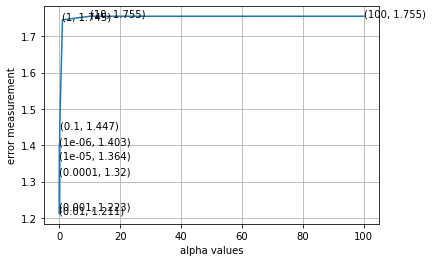

Log_loss for alpha  0.01 is  0.7107121426193821
Log_loss for alpha  0.01 is  1.1754755843569886
Log_loss for alpha  0.01 is  1.2109459031940473


In [185]:
alpha=[10**x for x in range(-6,3)]
cv_log_error=[]
for i in alpha:
    clf=SGDClassifier(alpha=i,penalty='l2',loss='hinge',class_weight='balanced',random_state=42)
    clf.fit(train_x_onehot,train_y)
    sig_clf=CalibratedClassifierCV(clf,method='sigmoid')
    sig_clf.fit(train_x_onehot,train_y)
    predict_y=sig_clf.predict_proba(cv_x_onehot)
    cv_log_error.append(log_loss(cv_y,predict_y,labels=clf.classes_,eps=1e-15))
    print('Log_loss for alpha ',i,'is ',log_loss(cv_y,predict_y,labels=clf.classes_,eps=1e-15))
    
fig,ax=plt.subplots()
ax.plot(alpha,np.round(cv_log_error,3))
for i,text in enumerate(np.round(cv_log_error,3)):
    ax.annotate((alpha[i],np.round(text,3)),(alpha[i],cv_log_error[i]))
plt.xlabel('alpha values')
plt.ylabel('error measurement')
plt.grid()
plt.show()

bestalpha=np.argmin(cv_log_error)
clf=SGDClassifier(alpha=alpha[bestalpha],penalty='l2',loss='hinge',class_weight='balanced',random_state=42)
clf.fit(train_x_onehot,train_y)
sig_clf=CalibratedClassifierCV(clf,method='sigmoid')
sig_clf.fit(train_x_onehot,train_y)

predict_y=sig_clf.predict_proba(train_x_onehot)
print('Log_loss for alpha ',alpha[bestalpha],'is ',log_loss(y_train_cv,predict_y,labels=clf.classes_,eps=1e-15))

predict_y=sig_clf.predict_proba(test_x_onehot)
print('Log_loss for alpha ',alpha[bestalpha],'is ',log_loss(y_test,predict_y,labels=clf.classes_,eps=1e-15))

predict_y=sig_clf.predict_proba(cv_x_onehot)
print('Log_loss for alpha ',alpha[bestalpha],'is ',log_loss(y_test_cv,predict_y,labels=clf.classes_,eps=1e-15))

Log_loss  1.2109459031940473
Number of misclassified points 0.37781954887218044
-------------------- Confusion matrix --------------------


<ipython-input-18-0c2a6ba47767>:4: RuntimeWarning: invalid value encountered in true_divide
  B = (C/C.sum(axis=0))


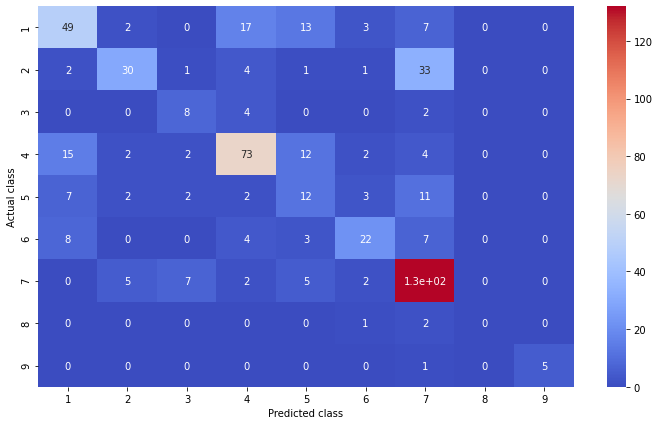

-------------------- Precision matrix --------------------


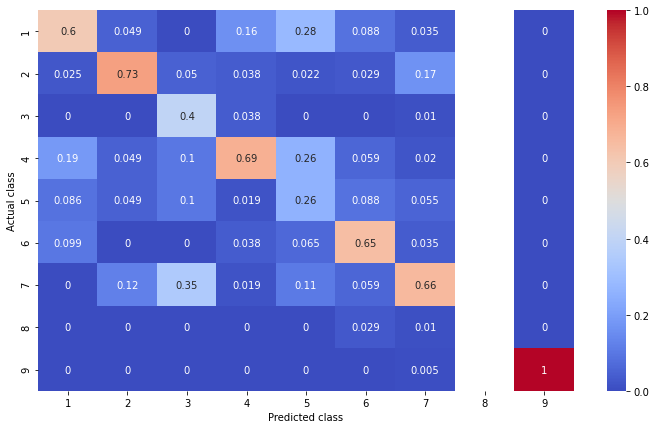

-------------------- Recall matrix --------------------


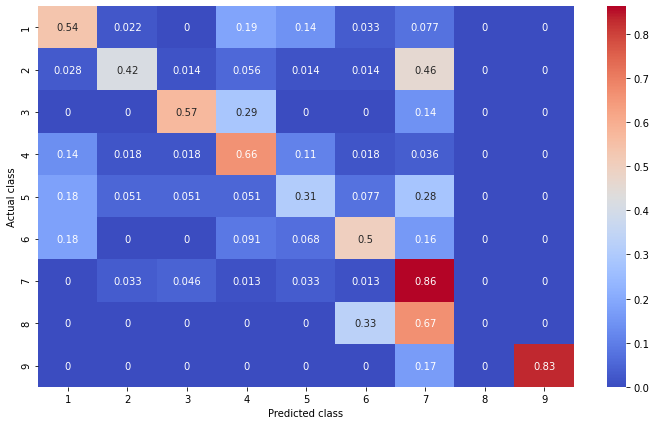

In [186]:
clf=SGDClassifier(alpha=alpha[bestalpha],penalty='l2',loss='hinge',class_weight='balanced',random_state=42)
predict_and_plot_confusion_matrix(train_x_onehot,train_y,cv_x_onehot,cv_y,clf)

In [187]:
clf=SGDClassifier(alpha=alpha[bestalpha],penalty='l2',loss='hinge',class_weight='balanced',random_state=42)
clf.fit(train_x_onehot,train_y)
sig_clf=CalibratedClassifierCV(clf,method='sigmoid')
sig_clf.fit(train_x_onehot,train_y)
x_test_point=5
no_features=100
#predict_y=sig_clf.predict_proba(cv_x_onehot)
predict_class=sig_clf.predict(test_x_onehot[x_test_point])
print('Predicted class :',predict_class)
print('Probabilities of each class ',sig_clf.predict_proba(test_x_onehot[x_test_point]))
print('Actual class :',test_y[x_test_point])
print('-'*50)


Predicted class : [2]
Probabilities of each class  [[0.03897987 0.86181575 0.00404135 0.02398067 0.01380765 0.00797563
  0.04205107 0.00342551 0.0039225 ]]
Actual class : 2
--------------------------------------------------
Out of the top  100  features  0 are present in query point


# Random Forest

In [169]:
alpha=[100,200,500,1000,2000]
max_depth=[5,10]
cv_log_error=[]
for i in alpha:
    for j in max_depth:
        clf=RandomForestClassifier(n_estimators=i,max_depth=j,criterion='gini',random_state=42,n_jobs=-1)
        clf.fit(train_x_onehot,train_y)
        sig_clf=CalibratedClassifierCV(clf,method='sigmoid')
        sig_clf.fit(train_x_onehot,train_y)
        predict_y=sig_clf.predict_proba(cv_x_onehot)
        cv_log_error.append(log_loss(cv_y,predict_y,labels=clf.classes_,eps=1e-15))
        print('for n_estimators = ',i,' and max depth = ', 5)
        print('Log_loss :',log_loss(cv_y,predict_y,labels=clf.classes_,eps=1e-15))
        
        
bestalpha=np.argmin(cv_log_error)
clf=RandomForestClassifier(n_estimators=alpha[int(bestalpha/2)],max_depth=max_depth[int(bestalpha%2)],criterion='gini',random_state=42,n_jobs=-1)
clf.fit(train_x_onehot,train_y)
sig_clf=CalibratedClassifierCV(clf,method='sigmoid')
sig_clf.fit(train_x_onehot,train_y)

predict_y=sig_clf.predict_proba(train_x_onehot)
print('Log_loss for best estimator ',alpha[int(bestalpha/2)] ,'and best max_depth ',max_depth[int(bestalpha%2)] ,'is ',log_loss(y_train_cv,predict_y,labels=clf.classes_,eps=1e-15))

predict_y=sig_clf.predict_proba(test_x_onehot)
print('Log_loss for best estimator ',alpha[int(bestalpha/2)] ,'and best max_depth ',max_depth[int(bestalpha%2)] ,'is ',log_loss(y_test,predict_y,labels=clf.classes_,eps=1e-15))

predict_y=sig_clf.predict_proba(cv_x_onehot)
print('Log_loss for best estimator ',alpha[int(bestalpha/2)] ,'and best max_depth ',max_depth[int(bestalpha%2)] ,'is ',log_loss(y_test_cv,predict_y,labels=clf.classes_,eps=1e-15))

for n_estimators =  100  and max depth =  5
Log_loss : 1.2886654934661175
for n_estimators =  100  and max depth =  5
Log_loss : 1.2279037641938395
for n_estimators =  200  and max depth =  5
Log_loss : 1.2834180392940082
for n_estimators =  200  and max depth =  5
Log_loss : 1.216590898882699
for n_estimators =  500  and max depth =  5
Log_loss : 1.2747187322120506
for n_estimators =  500  and max depth =  5
Log_loss : 1.2105052223929784
for n_estimators =  1000  and max depth =  5
Log_loss : 1.2703308707995937
for n_estimators =  1000  and max depth =  5
Log_loss : 1.2056557250394293
for n_estimators =  2000  and max depth =  5
Log_loss : 1.2724743590601775
for n_estimators =  2000  and max depth =  5
Log_loss : 1.205593320827375
Log_loss for best estimator  2000 and best max_depth  10 is  0.6662055129780534
Log_loss for best estimator  2000 and best max_depth  10 is  1.1836372195077696
Log_loss for best estimator  2000 and best max_depth  10 is  1.205593320827375


Log_loss  1.205593320827375
Number of misclassified points 0.40037593984962405
-------------------- Confusion matrix --------------------


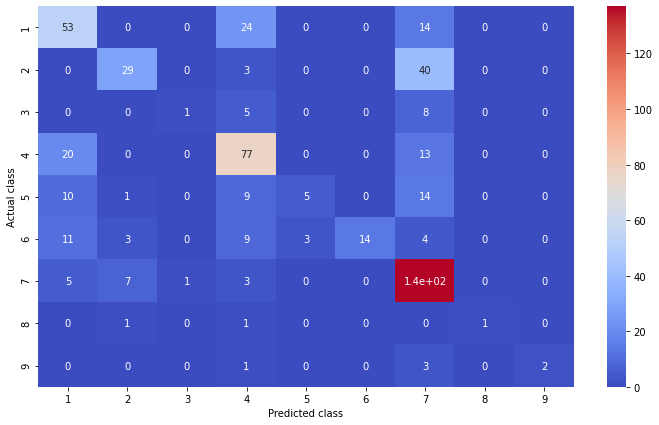

-------------------- Precision matrix --------------------


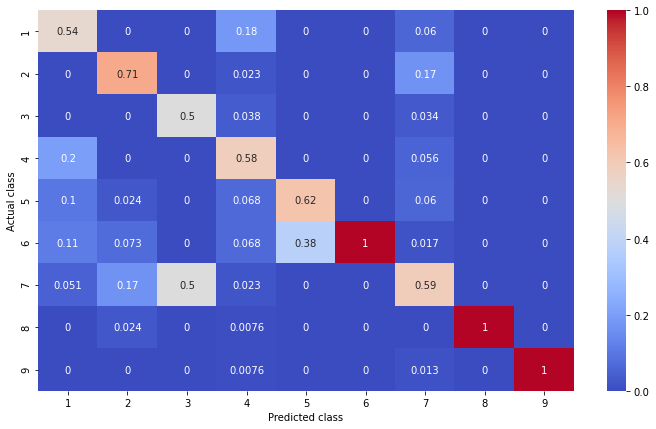

-------------------- Recall matrix --------------------


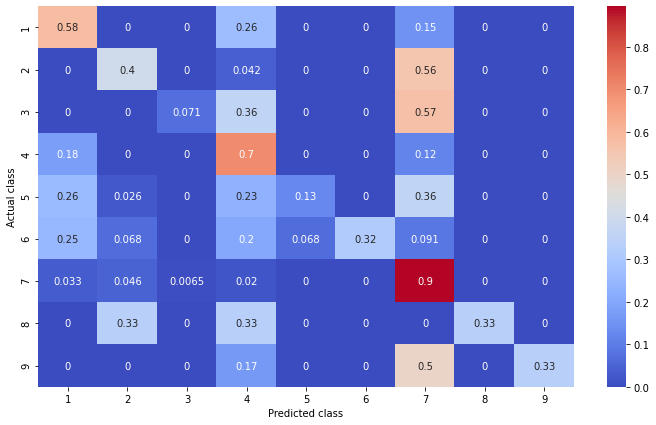

In [171]:
clf=RandomForestClassifier(n_estimators=alpha[int(bestalpha/2)],max_depth=max_depth[int(bestalpha%2)],criterion='gini',random_state=42,n_jobs=-1)
predict_and_plot_confusion_matrix(train_x_onehot,train_y,cv_x_onehot,cv_y,clf)

In [176]:
clf=RandomForestClassifier(n_estimators=alpha[int(bestalpha/2)],max_depth=max_depth[int(bestalpha%2)],criterion='gini',random_state=42,n_jobs=-1)
clf.fit(train_x_onehot,train_y)
sig_clf=CalibratedClassifierCV(clf,method='sigmoid')
sig_clf.fit(train_x_onehot,train_y)
x_test_point=6
no_features=100
predicted_class = sig_clf.predict(test_x_onehot[x_test_point])
print('Predicted_class :',predicted_class)
print('Probability of belonging to each class ',sig_clf.predict_proba(test_x_onehot[x_test_point]))
print('Actual class ',test_y[x_test_point])
print('-'*50)


Predicted_class : [7]
Probability of belonging to each class  [[0.02481864 0.12739916 0.01515348 0.02298809 0.03355313 0.03047121
  0.73777708 0.0044727  0.00336649]]
Actual class  7
--------------------------------------------------
0 Text feature [kinase] present in test data point [True]
1 Text feature [inhibitors] present in test data point [True]
2 Text feature [activating] present in test data point [True]
3 Text feature [activation] present in test data point [True]
4 Text feature [tyrosine] present in test data point [True]
5 Text feature [constitutive] present in test data point [True]
6 Text feature [phosphorylation] present in test data point [True]
7 Text feature [inhibitor] present in test data point [True]
9 Text feature [activated] present in test data point [True]
10 Text feature [signaling] present in test data point [True]
11 Text feature [oncogenic] present in test data point [True]
13 Text feature [treatment] present in test data point [True]
15 Text feature [functi

# Stacking Classifier

In [ ]:
#we loose interpretebility while combining

In [180]:
clf1=SGDClassifier(alpha=0.001,penalty='l2',loss='log',random_state=0,class_weight='balanced')
clf1.fit(train_x_onehot,train_y)
sig_clf1=CalibratedClassifierCV(clf,method='sigmoid')

clf2=SGDClassifier(alpha=1,penalty='l2',loss='hinge',random_state=0,class_weight='balanced')
clf2.fit(train_x_onehot,train_y)
sig_clf2=CalibratedClassifierCV(clf,method='sigmoid')

clf3=MultinomialNB(alpha=0.001)
clf3.fit(train_x_onehot,train_y)
sig_clf3=CalibratedClassifierCV(clf,method='sigmoid')

sig_clf1.fit(train_x_onehot,train_y)
print('Log_loss for logistic regression :',log_loss(cv_y,sig_clf1.predict_proba(cv_x_onehot)))

sig_clf2.fit(train_x_onehot,train_y)
print('Log_loss for SVM :',log_loss(cv_y,sig_clf2.predict_proba(cv_x_onehot)))

sig_clf3.fit(train_x_onehot,train_y)
print('Log_loss for Naive bayes :',log_loss(cv_y,sig_clf3.predict_proba(cv_x_onehot)))

alpha = [0.0001,0.001,0.01,0.1,1,10] 
best_alpha = 999
for i in alpha:
    lr=LogisticRegression(C=i)
    sclf=StackingClassifier(classifiers=[sig_clf1,sig_clf2,sig_clf3],meta_classifier=lr,use_probas=True)
    sclf.fit(train_x_onehot,train_y)
    print('stacking classifier the value of alpha ',i,'is ',log_loss(cv_y,sclf.predict_proba(cv_x_onehot)))
    log_error=log_loss(cv_y,sclf.predict_proba(cv_x_onehot))
    if best_alpha>log_error:
        best_alpha=log_error

Log_loss for logistic regression : 1.205593320827375
Log_loss for SVM : 1.205593320827375
Log_loss for Naive bayes : 1.205593320827375
stacking classifier the value of alpha  0.0001 is  1.815472967968022
stacking classifier the value of alpha  0.001 is  1.70821005343322
stacking classifier the value of alpha  0.01 is  1.38273791210909
stacking classifier the value of alpha  0.1 is  1.2279718069070473
stacking classifier the value of alpha  1 is  1.2673494833865602


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


stacking classifier the value of alpha  10 is  1.3765105438390106


Log_loss(train) on the stacking classifier  0.601606492970089
Log_loss(test) on the stacking classifier  1.2428355489603014
Log_loss(cv) on the stacking classifier  1.2279718069070473
Number of misclassified points  665


<ipython-input-18-0c2a6ba47767>:4: RuntimeWarning: invalid value encountered in true_divide
  B = (C/C.sum(axis=0))


-------------------- Confusion matrix --------------------


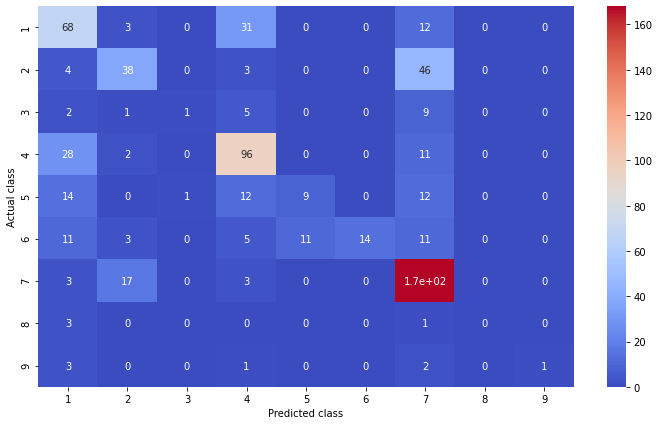

-------------------- Precision matrix --------------------


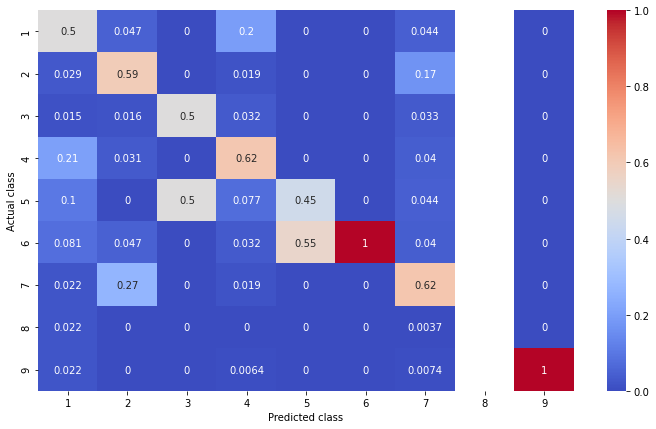

-------------------- Recall matrix --------------------


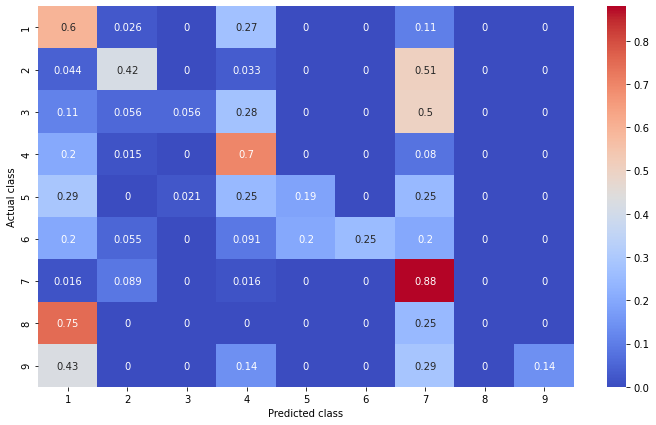

In [181]:
lr = LogisticRegression(C=0.1)
sclf=StackingClassifier(classifiers=[sig_clf1,sig_clf2,sig_clf3],meta_classifier=lr,use_probas=True)
sclf.fit(train_x_onehot,train_y)

log_error=log_loss(train_y,sclf.predict_proba(train_x_onehot))
print('Log_loss(train) on the stacking classifier ',log_error)

log_error=log_loss(test_y,sclf.predict_proba(test_x_onehot))
print('Log_loss(test) on the stacking classifier ',log_error)

log_error=log_loss(cv_y,sclf.predict_proba(cv_x_onehot))
print('Log_loss(cv) on the stacking classifier ',log_error)

print('Number of misclassified points ',np.count_nonzero(sclf.predict(test_x_onehot) - test_y/test_y.shape[0]))
plot_confusion_matrix(test_y,sclf.predict(test_x_onehot))

# Maximum Voting classifier ¶

In [ ]:
from sklearn.ensemble import VotingClassifier
vclf=VotingClassifier(estimators=[('lr',sig_clf1),('svc',sig_clf2),('rf',sig_clf3)],voting='soft')
vclf.fit(train_x_onehot,train_y)
print('Log_loss(train) on voting classifier ',log_loss(train_y,vlcf.predict_proba(train_x_onehot)))
print('Log_loss(train) on voting classifier ',log_loss(test_y,vlcf.predict_proba(test_x_onehot)))
print('Log_loss(train) on voting classifier ',log_loss(cv_y,vlcf.predict_proba(cv_x_onehot)))
print('Number of misclassified points ',np.count_nonzero(test_y-vlcf.predict(test_x_onehot)/test_y.shape[0]))
plot_confusion_matrix(test_y,test_x_onehot)

In [ ]:
#here we are summing up the probabilities of each  model for each class and finding its mean whichever class gives higher mean 
#is considered